In [ ]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

In [ ]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("c", "d")
builder.add_edge("b", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

KeyboardInterrupt: 

In [ ]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## Cusom reducers (Sorting)

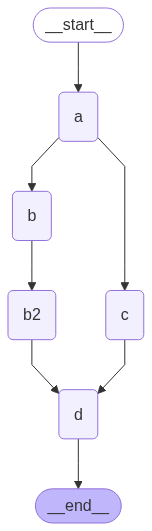

In [ ]:
import operator
from typing import Annotated

def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        
        left = [left]
    # print("left:", left)
    if not isinstance(right, list):
        
        right = [right]
    # print("right:", right)
    return sorted(left + right)

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, sorting_reducer]


# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"state": []})

left: []
right: []
Adding I'm A to []
left: []
right: ["I'm A"]
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
left: ["I'm A"]
right: ["I'm B"]
left: ["I'm A", "I'm B"]
right: ["I'm C"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
left: ["I'm A", "I'm B", "I'm C"]
right: ["I'm B2"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]
left: ["I'm A", "I'm B", "I'm B2", "I'm C"]
right: ["I'm D"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

## Working with llm

In [23]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated
import operator
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from dotenv import load_dotenv
import os
load_dotenv()  # tự động tìm và đọc file .env

True

In [24]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]


llm: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)

In [25]:
def search_web(state):
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def generate_answer(state):
    answer_template = "Answer the question {question} using this context {context}"
    answer_instructions = answer_template.format(
        question=state["question"], context=state["context"])
    
    answer = llm.invoke([SystemMessage(content=answer_instructions)] +
                        [HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}

    

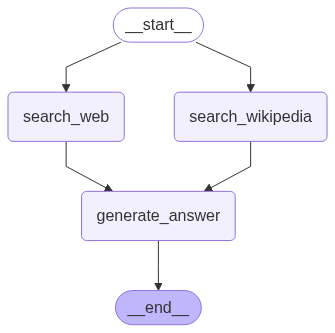

In [26]:
builder = StateGraph(State)

builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_web")
builder.add_edge(START, "search_wikipedia")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"<think>\nOkay, let's tackle this question. The user wants to know how Nvidia's Q2 2024 earnings performed, based on the provided context.\n\nFirst, I need to look through the documents given. There are a few key points mentioned. One document talks about Nvidia's Q2 earnings showing strong performance in AI and data centers, with a $50 billion stock buyback. Another document has financial details from the Q2 report, including operating expenses, operating income, net income, and diluted EPS. The numbers there show significant increases, like operating income up 155% and net income up 148%. \n\nBut then there's another document mentioning product issues affecting gross margins, which caused a decline in margins between Q1 and Q2. That's a negative factor. Also, the Wikipedia entry about Nvidia mentions their market position and valuation, but the specific earnings details are in the other documents.\n\nSo putting it together: The earnings were strong, with record revenue and a big buyb

In [29]:
result["context"]

['<Document href="https://www.tastylive.com/news-insights/nvidia-nvda-6-key-takeaways-q2-earnings-report">\n![Screenshot_2024-08-29_at_8.04.47_AM.png](https://images.contentstack.io/v3/assets/blt40263f25ec36953f/blt18b79c7e96665ed7/66d08075ed20cf41fdc338a6/Screenshot_2024-08-29_at_8.04.47_AM.png?format=pjpg&auto=webp&quality=50&width=1000&disable=upscale)\n\n# **The investment outlook**\n\nNvidia’s Q2 earnings showcased strong performance, reinforcing its leading role in AI and data centers. However, a few challenges have emerged alongside those positive results. [...] The Six Most Important Takeaways From Nvidia\'s Q2 Earnings Report\n\n![uploaded image]()\n\nAug 29, 2024\n\n# The Six Most Important Takeaways From Nvidia\'s Q2 Earnings Report\n\nBy:[Andrew Prochnow](/authors/andrew-prochnow)\n\n## In the AI chip sector, Nvidia remains the undisputed heavyweight.\n\n**Nvidia’s Q2 earnings report showed the company remains a tech juggernaut that dominates the AI-focused chip market.**\n